In [12]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/train.csv')

In [13]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comm: sum(1 for c in comm if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)

train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))

train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']

In [15]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_words,num_unique_words,words_vs_unique
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,17,0.064394,0,1,6,43,41,0.953488
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,8,0.071429,1,0,5,17,17,1.000000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,4,0.017167,0,0,4,42,39,0.928571
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,11,0.017685,0,0,6,113,82,0.725664
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,2,0.029851,0,1,3,13,13,1.000000


In [18]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
            'num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',
            'words_vs_unique')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

In [19]:
train_correlations

,identity_hate,insult,obscene,severe_toxic,threat,toxic
total_length,-0.013647,-0.045052,-0.042945,0.010131,-0.008011,-0.054470
capitals,0.053576,0.075945,0.081691,0.143410,0.033581,0.091175
caps_vs_length,0.093726,0.170384,0.182452,0.169243,0.055596,0.220777
num_exclamation_marks,0.006005,0.027010,0.024362,0.060578,0.034202,0.037337
num_question_marks,-0.000516,0.004859,0.005404,-0.004541,-0.003949,0.027820
num_punctuation,-0.021698,-0.049487,-0.044119,-0.010763,-0.003723,-0.056714
num_words,-0.014493,-0.043642,-0.042207,0.008452,-0.006688,-0.052444
num_unique_words,-0.032796,-0.080960,-0.080942,-0.048377,-0.020279,-0.096256
words_vs_unique,0.010632,0.043348,0.042755,-0.027050,-0.004020,0.056491


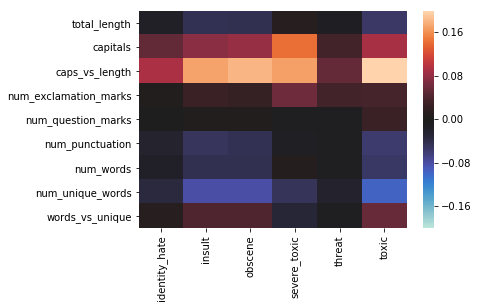

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.heatmap(train_correlations, vmin=-0.2, vmax=0.2, center=0.0)

plt.show()

In [26]:
test = pd.read_csv('./data/test.csv')

In [27]:
test.shape

(153164, 2)

In [28]:
train.shape

(159571, 17)

In [33]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [34]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [37]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

In [52]:
test['total_length'] = test['comment_text'].apply(len)
test['capitals'] = test['comment_text'].apply(lambda comm: sum(1 for c in comm if c.isupper()))
test['caps_vs_length'] = test.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)

test['num_exclamation_marks'] = test['comment_text'].apply(lambda comment: comment.count('!'))
test['num_question_marks'] = test['comment_text'].apply(lambda comment: comment.count('?'))
test['num_punctuation'] = test['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))

test['num_words'] = test['comment_text'].apply(lambda comment: len(comment.split()))
test['num_unique_words'] = test['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))
test['words_vs_unique'] = test['num_unique_words'] / test['num_words']

In [75]:
from sklearn.model_selection import train_test_split

targets = ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

x = train.drop(targets, axis=1)

test_x = test.drop(['id'], axis=1)
x = x.drop(['id'], axis=1)

In [81]:
x = trn_term_doc
test_x = test_term_doc

# x = x.drop(['comment_text'], axis=1)
# test_x = test_x.drop(['comment_text'], axis=1)

# x = x.fillna(0)
# test_x = test_x.fillna(0)

# x.shape

In [82]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [99]:
from sklearn.svm import SVC
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = SVC(C=4, probability=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [85]:
x

<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
	with 17775104 stored elements in Compressed Sparse Row format>

In [ ]:
preds = np.zeros((len(test), len(targets)))

for i, j in enumerate(targets):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit identity_hate
fit insult


In [93]:
subm = pd.read_csv('./data/sample_submission.csv')

submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = targets)], axis=1)
submission.to_csv('./data/submission.csv', index=False)

In [94]:
submission.head()

,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,00001cee341fdb12,0.094954,0.962578,0.999987,0.106264,0.002368,0.999988
1,0000247867823ef7,0.000342,0.002227,0.001893,0.000604,0.000100,0.002873
2,00013b17ad220c46,0.000297,0.003210,0.005588,0.000864,0.000102,0.011755
3,00017563c3f7919a,0.000297,0.001057,0.001141,0.000224,0.000171,0.000960
4,00017695ad8997eb,0.000351,0.002395,0.002009,0.000485,0.000131,0.009957
